In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from construct import *

import sys
sys.path.append('/home/scott/Dropbox/satobs/STEREO_A/')
import ccsds

import collections
import datetime
import struct

plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
def process_frames(input_file, output_file):
    frame_length = 8952
    new_frame_length = 8920
    bits_to_remove = 32

    with open(input_file, 'rb') as f_in, open(output_file, 'wb') as f_out:
        while True:
            frame = f_in.read(frame_length // 8)  # Read frame in bytes
            if not frame:  # Reached end of file
                break
            new_frame = frame[bits_to_remove // 8:]  # Remove first 32 bits
            f_out.write(new_frame)

    print(f"Processed {input_file}. New file saved as {output_file}.")

#satdump .cadu filename
input_filename = '/home/scott/Downloads/20230706_Fred_stereo_lr.cadu'

#stripped output file compatible with the script below
output_filename = 'output_frames.bin'
process_frames(input_filename, output_filename)


Processed /home/scott/Downloads/20230706_Fred_stereo_lr.cadu. New file saved as output_frames.bin.


In [3]:
def load_frames(file):
    frame_size = 223 * 5
    frames = np.fromfile(file, dtype = 'uint8')
    return frames[:frames.size//frame_size*frame_size].reshape(-1, frame_size)

#frames = load_frames('stereo-a_bg2bhc_frames_20220924_0710.raw')
#frames = load_frames('stereo-a_bg2bhc_frames_20220924_1035.raw')
frames = load_frames('output_frames.bin')

In [4]:
# Filename extensions 

# .711 COR2
# .725 hi_1
# .734 hi_2
# .743 EUV


In [5]:
import numpy as np

def print_ascii_sequences(frames):
    ascii_sequence = ""
    for byte in np.nditer(frames):
        if 32 <= byte <= 126:
            ascii_sequence += chr(byte)
        else:
            if len(ascii_sequence) > 11:
                print(ascii_sequence)
            ascii_sequence = ""
    if len(ascii_sequence) > 1:
        print(ascii_sequence)



#print ASCII strings greater than 11 chars long, these tend to be filenames.
print_ascii_sequences(frames)


kN706020B.743
kN706020B.743
kN706020D.743
kN706020D.743
kN706021H.743
kN706021H.743
kN706022O.743
kN706022O.743
N7060236.711
N7060236.711
N706023A.711
N706023A.711
N706023E.711
N706023E.711
kN7060241.743
kN7060241.743
kN7060244.743
kN7060244.743
N706224F.725
N706224F.725
kN7060253.743
kN7060253.743
kN7060266.743
kN7060266.743
kN706027F.743
kN706027F.743
kN706027I.743
kN706027I.743
N706227R.734
CMW[Y_[qYkekgimmyimmm[kYWG
N706227R.734
kN706028G.743
kN706028G.743
kN7060296.743
kN7060296.743
N706029I.711
N706029I.711
N706029M.711
"i3mN>P4eL]1
N706029M.711
N706029Q.711
N706029Q.711
kN70602AD.743
kN70602AD.743
kN70602AG.743
kN70602AG.743
kN70602BM.743
~hVxj?Z"`sL/
kN70602BM.743
kN70602CS.743
kN70602CS.743
HWC$AVBsBdC9A
kN70602DU.743
Df}i%X`YIc{KI}
kN70602DU.743
kN70602DW.743
kN70602DW.743
kN70602F0.743
kN70602F0.743
kN70602G7.743
kN70602G7.743
N70602GP.711
Lr6{X*b`-`ci
N70602GP.711
N70602GT.711
N70602GT.711
N70602GX.711
N70602GX.711
kN70602HK.743
kN70602HK.743
kN70602HN.743
kN70602HN.743
N70

## TM Primary Headers

The frames are TM Space Data Link frames. The spacecraft ID is 234 (0xEA). Virtual channels 0 and 7 are in use. OCF and secondary headers are used.

In [6]:
TMPrimaryHeader = BitStruct(
    'transfer_frame_version_number' / BitsInteger(2),
    'spacecraft_id' / BitsInteger(10),
    'virtual_channel_id' / BitsInteger(3),
    'ocf_flag' / Flag,
    'master_channel_frame_count' / BitsInteger(8),
    'virtual_channel_frame_count' / BitsInteger(8),
    'secondary_header_flag' / Flag,
    'synch_flag' / Flag,
    'packet_order_flag' / Flag,
    'segment_length_id' / BitsInteger(2),
    'first_header_pointer' / BitsInteger(11)
)

TransferFrameSecondaryHeaderId = BitStruct(
    'version_number' / BitsInteger(2),
    'header_length' / BitsInteger(6)
)

CLCW = BitStruct(
    'control_word_type' / Flag,
    'clcw_version_number' / BitsInteger(2),
    'status_field' / BitsInteger(3),
    'cop_in_effect' / BitsInteger(2),
    'virtual_channel_identification' / BitsInteger(6),
    'rsvd_spare' / BitsInteger(2),
    'no_rf_avail' / Flag,
    'no_bit_lock' / Flag,
    'lock_out' / Flag,
    'wait' / Flag,
    'retransmit' / Flag,
    'farm_b_counter' / BitsInteger(2),
    'rsvd_spare2' / BitsInteger(1),
    'report_value' / BitsInteger(8)
)

In [7]:
tm = [TMPrimaryHeader.parse(f) for f in frames]
scid = np.array([h.spacecraft_id for h in tm])
vcid = np.array([h.virtual_channel_id for h in tm])
v_framecount = np.array([h.virtual_channel_frame_count for h in tm])
m_framecount = np.array([h.master_channel_frame_count for h in tm])

In [8]:
tm[:5]

[Container(transfer_frame_version_number=0, spacecraft_id=234, virtual_channel_id=7, ocf_flag=True, master_channel_frame_count=142, virtual_channel_frame_count=98, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=0),
 Container(transfer_frame_version_number=0, spacecraft_id=234, virtual_channel_id=7, ocf_flag=True, master_channel_frame_count=143, virtual_channel_frame_count=99, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=0),
 Container(transfer_frame_version_number=0, spacecraft_id=234, virtual_channel_id=7, ocf_flag=True, master_channel_frame_count=144, virtual_channel_frame_count=100, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=0),
 Container(transfer_frame_version_number=0, spacecraft_id=234, virtual_channel_id=7, ocf_flag=True, master_channel_frame_count=145, virtual_channel_frame_co

In [9]:
collections.Counter(scid)

Counter({234: 2013})

In [10]:
collections.Counter(vcid)

Counter({7: 1944, 0: 69})

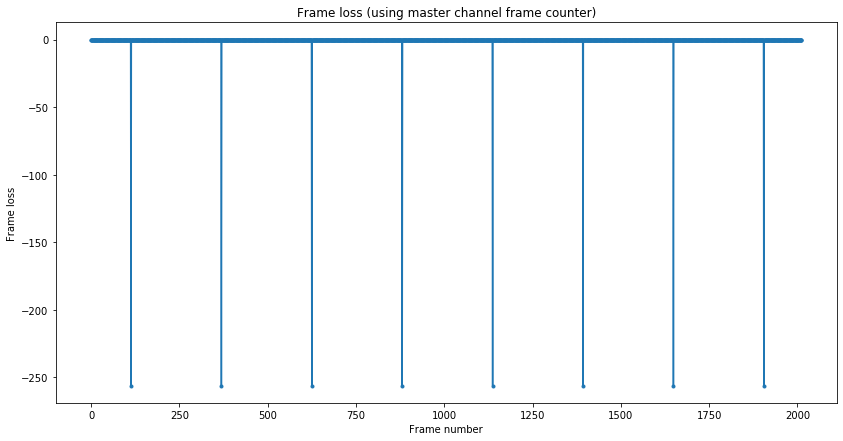

In [11]:
plt.plot(np.diff(m_framecount) - 1, '.-')
plt.title('Frame loss (using master channel frame counter)')
plt.ylabel('Frame loss')
plt.xlabel('Frame number');

## TM Secondary Header

The TM Secondary Header contains a timestamp giving the seconds since 2006-10-25 12:00 UTC as a 32-bit integer, plus an additional 8-bit integer that counts 1/256-ths of a second. The remaining 9 bytes of the header are filled with `0x00` in the virtual channel 7 frames and with `0xff` in the virtual channel 0 frames.

In [12]:
sec_header_id = [TransferFrameSecondaryHeaderId.parse(f[TMPrimaryHeader.sizeof():])
                 for f in frames]
all([sec_header_id[0] == h for h in sec_header_id])

True

In [13]:
sec_header_id[0]

Container(version_number=0, header_length=14)

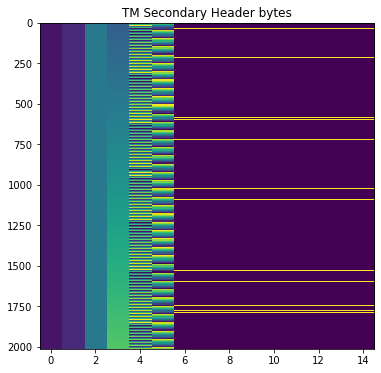

In [14]:
plt.figure(figsize=(6, 6))
plt.imshow(frames[:, 6:6+15], interpolation='none', aspect='auto')
plt.title('TM Secondary Header bytes');

In [15]:
np.all(frames[vcid != 0, 12:6+15] == 0)

True

In [16]:
np.all(frames[vcid == 0, 12:6+15] == 0xff)

True

In [17]:
#timestamps_secs = (
   # frames[:, 7:11].view('uint32').byteswap().ravel().astype('float')+ frames[:, 11].astype('float') / 256)
    
timestamps_secs = (frames[:, 7:11].copy().view('uint32').byteswap().ravel().astype('float')+ frames[:, 11].astype('float') / 256)


In [18]:
np.diff(timestamps_secs)

array([14.140625  , 14.14453125, 14.140625  , ..., 14.140625  ,
       14.14453125, 14.140625  ])

In [19]:
(5*223*8 + 4 + 32) * 6 / 3.8e3

14.141052631578948

In [20]:
1/256

0.00390625

In [21]:
datetime.datetime(2022, 9, 24, 10, 35, 0) - datetime.timedelta(seconds=timestamps_secs[0])

datetime.datetime(2006, 1, 13, 11, 35, 25, 515625)

In [22]:
epoch = np.datetime64('2006-10-25T12:00:00')

In [23]:
timestamps = epoch + np.timedelta64(1, 'ns') * (timestamps_secs * 1e9)

In [24]:
timestamps[0]

numpy.datetime64('2023-07-06T10:59:34.484374976')

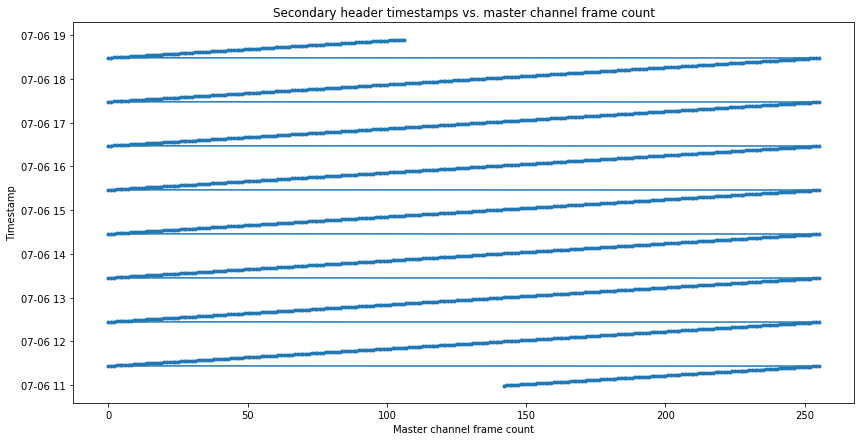

In [25]:
plt.plot(m_framecount, timestamps, '.-')
plt.title('Secondary header timestamps vs. master channel frame count')
plt.xlabel('Master channel frame count')
plt.ylabel('Timestamp');

## Operational Control Field

The operational control field shows receiver lock, event though the frequency of the downlink transmitter changes during the recording (indicating loss of ground lock).

In [26]:
ocf = frames[:, -6:-2]
np.all(ocf == ocf[0])

True

In [27]:
print(CLCW.parse(ocf[0]))

Container: 
    control_word_type = False
    clcw_version_number = 0
    status_field = 0
    cop_in_effect = 1
    virtual_channel_identification = 2
    rsvd_spare = 0
    no_rf_avail = False
    no_bit_lock = False
    lock_out = False
    wait = False
    retransmit = False
    farm_b_counter = 3
    rsvd_spare2 = 0
    report_value = 23


## Virtual channel 0

Frames in virtual channel 0 carry OID (only idle data). The transfer frame data field is filled with `0xff` bytes.

In [28]:
[h for h in tm if h.virtual_channel_id == 0]

[Container(transfer_frame_version_number=0, spacecraft_id=234, virtual_channel_id=0, ocf_flag=True, master_channel_frame_count=148, virtual_channel_frame_count=205, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=2046),
 Container(transfer_frame_version_number=0, spacecraft_id=234, virtual_channel_id=0, ocf_flag=True, master_channel_frame_count=181, virtual_channel_frame_count=206, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=2046),
 Container(transfer_frame_version_number=0, spacecraft_id=234, virtual_channel_id=0, ocf_flag=True, master_channel_frame_count=182, virtual_channel_frame_count=207, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=2046),
 Container(transfer_frame_version_number=0, spacecraft_id=234, virtual_channel_id=0, ocf_flag=True, master_channel_frame_count=186, virtual_chann

In [29]:
np.all(frames[vcid == 0][:, 12:-6] == 0xff)

True

## Virtual channel 7

Frames in virtual channel 7 contain 4 Space Packets with a length of 272 bytes (which divides the transfer frame data field evenly in 4). The Space Packets in the non-idle APIDs have a Secondary Header with a 32-bit timestamp giving the number of seconds since the CCSDS time code epoch 1958-01-01 00:00:00 TAI.

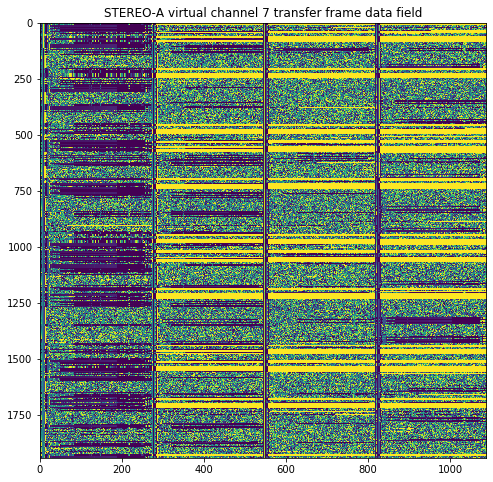

In [30]:
plt.figure(figsize=(8, 8))
plt.imshow(frames[vcid == 7, 6+15:-6], interpolation='none', aspect='auto')
plt.title('STEREO-A virtual channel 7 transfer frame data field');

In [31]:
# 265 bytes = Space Packet data length field (indicates length-1)
# 6 bytes = Space Packet primary header
# 4 Space Packets per TM frame
# 6 bytes = TM Primary Header
# 15 bytes = TM Secondary Header
# 4 bytes = OCF (CLCW)
# 2 bytes = FECF (CRC-16)
(265 + 1 + 6) * 4 + 6 + 15 + 4 + 2 == frames.shape[1]

True

In [32]:
packet_len = 265 + 1 + 6

In [33]:
packet_headers = [ccsds.SpacePacketPrimaryHeader.parse(f[6+15+k*packet_len:])
                  for f in frames[vcid == 7] for k in range(4)]

In [34]:
packet_headers[:5]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=880, sequence_flags=3, packet_sequence_count_or_name=14380, data_length=265),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=2141, data_length=265),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=2142, data_length=265),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=2143, data_length=265),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=0, sequence_flags=3, packet_sequence_count_or_name=7699, data_length=265)]

In [35]:
collections.Counter([h.ccsds_version for h in packet_headers])

Counter({0: 7776})

In [36]:
collections.Counter([h.packet_type for h in packet_headers])

Counter({0: 7776})

In [37]:
collections.Counter([h.secondary_header_flag for h in packet_headers])

Counter({True: 6624, False: 1152})

In [38]:
collections.Counter([h.APID for h in packet_headers])

Counter({880: 475,
         2047: 1152,
         0: 114,
         624: 474,
         1393: 474,
         1140: 2835,
         1137: 1266,
         1138: 170,
         1139: 816})

In [39]:
apids = {h.APID for h in packet_headers}
{apid: collections.Counter([
    h.secondary_header_flag
    for h in packet_headers if h.APID == apid]) for apid in apids}

{0: Counter({True: 114}),
 880: Counter({True: 475}),
 624: Counter({True: 474}),
 1393: Counter({True: 474}),
 1137: Counter({True: 1266}),
 1140: Counter({True: 2835}),
 1138: Counter({True: 170}),
 1139: Counter({True: 816}),
 2047: Counter({False: 1152})}

In [40]:
collections.Counter([h.sequence_flags for h in packet_headers])

Counter({3: 7776})

In [41]:
collections.Counter([h.data_length for h in packet_headers])

Counter({265: 7776})

In [42]:
space_packets = [f[6+15+k*packet_len:][:packet_len]
                 for f in frames[vcid == 7] for k in range(4)]
by_apid = {apid: [] for apid in apids}
for packet, header in zip(space_packets, packet_headers):
    by_apid[header.APID].append(packet)
by_apid = {apid: np.array(by_apid[apid]) for apid in apids}

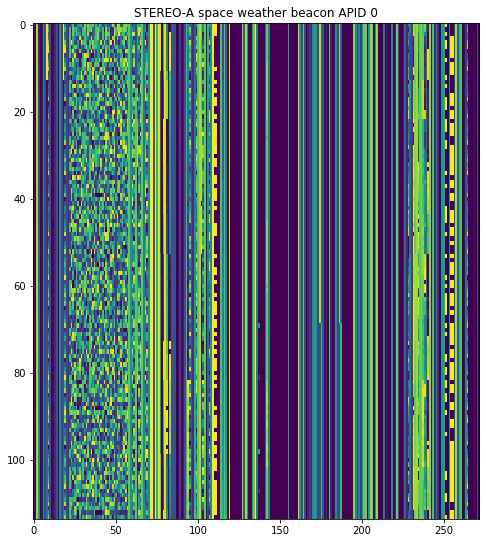

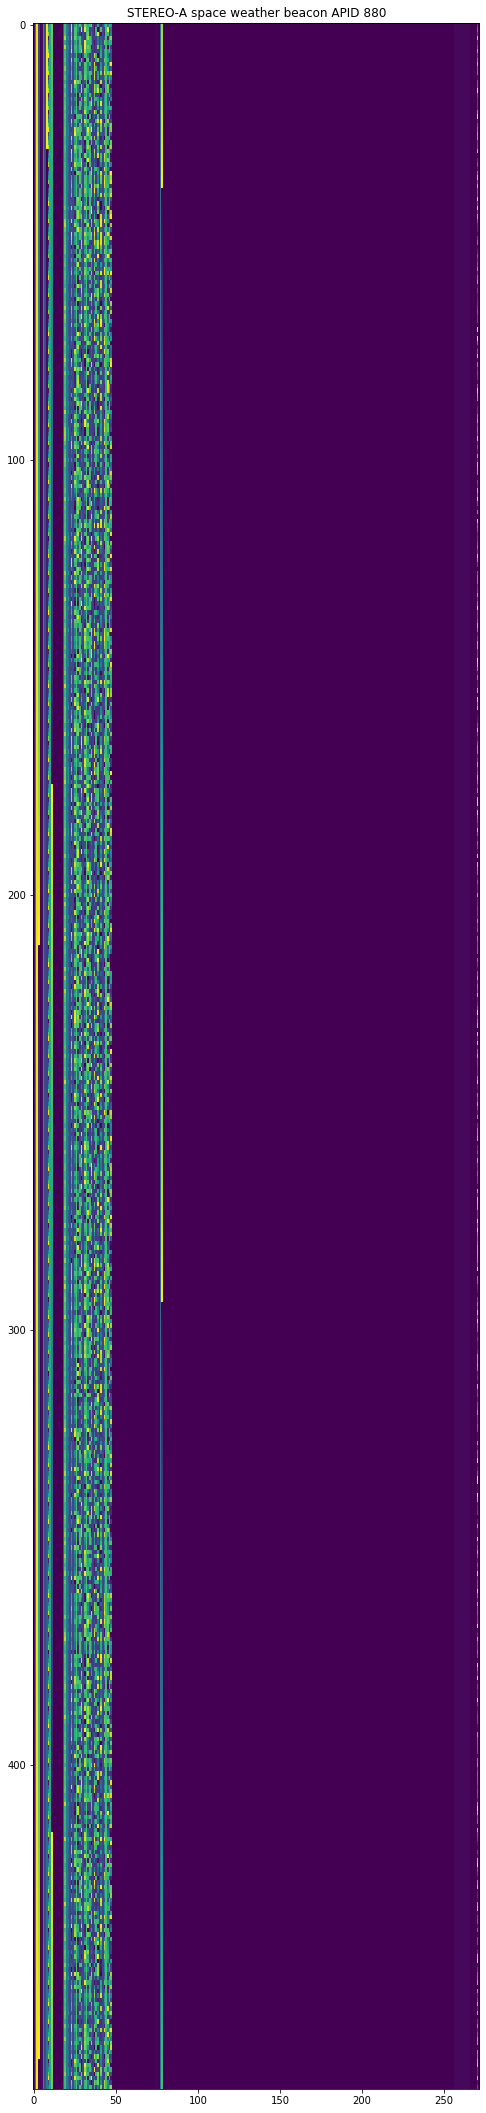

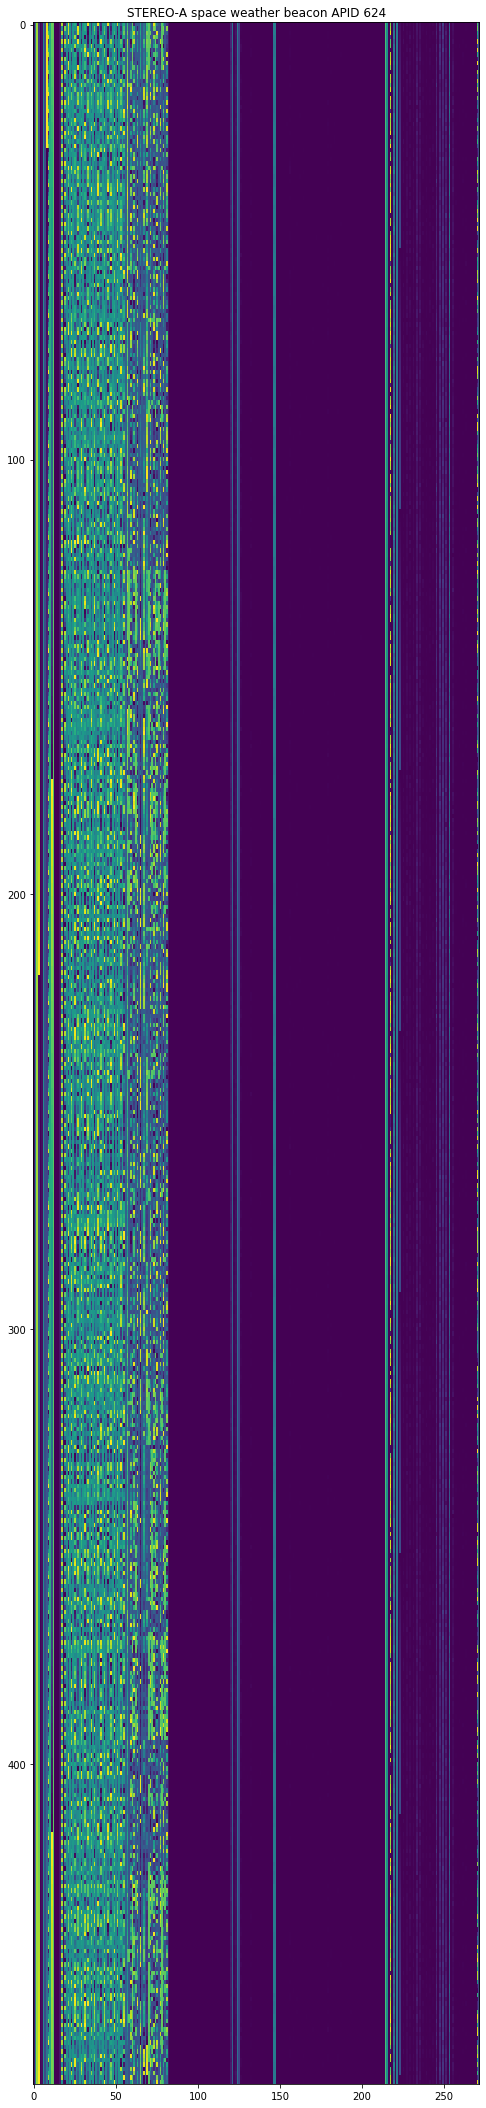

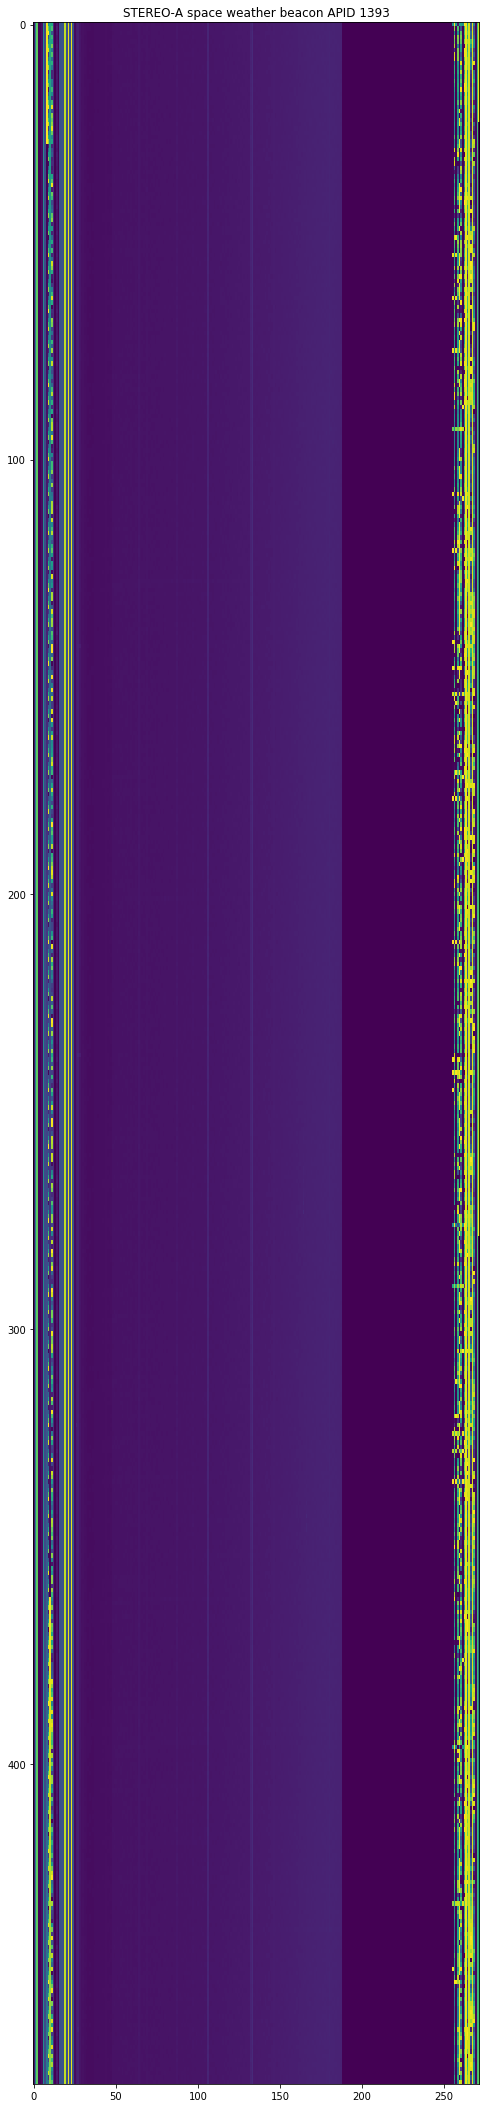

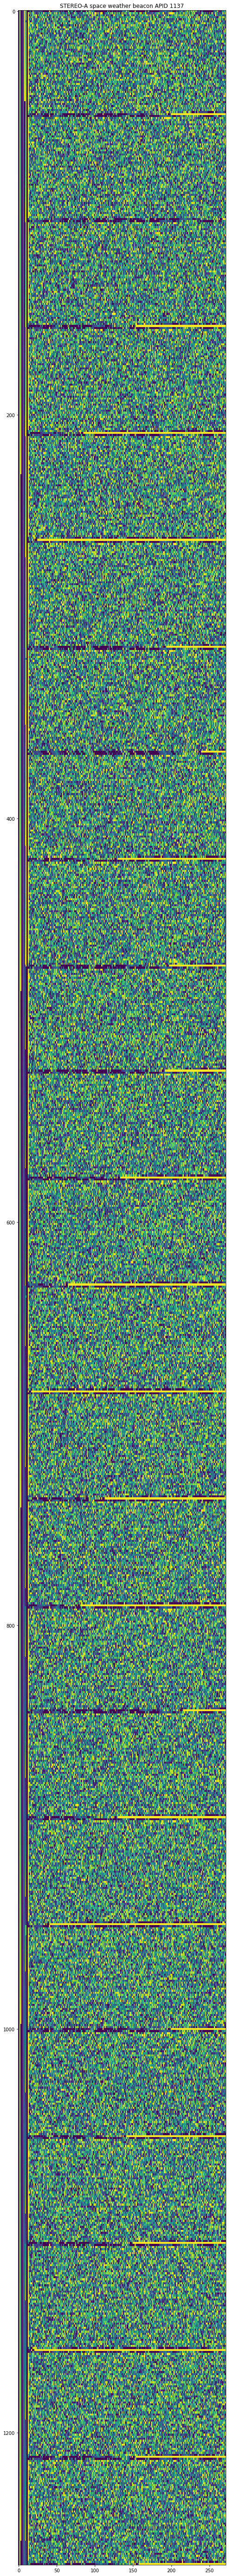

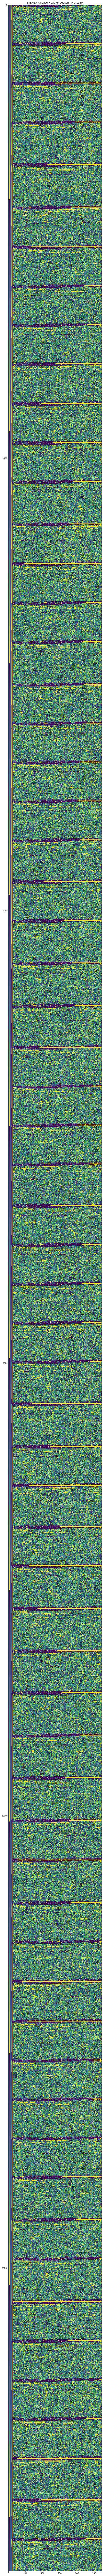

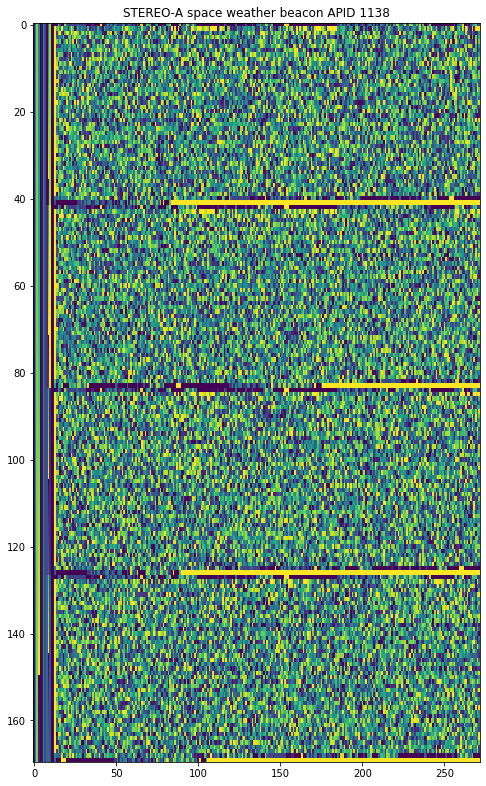

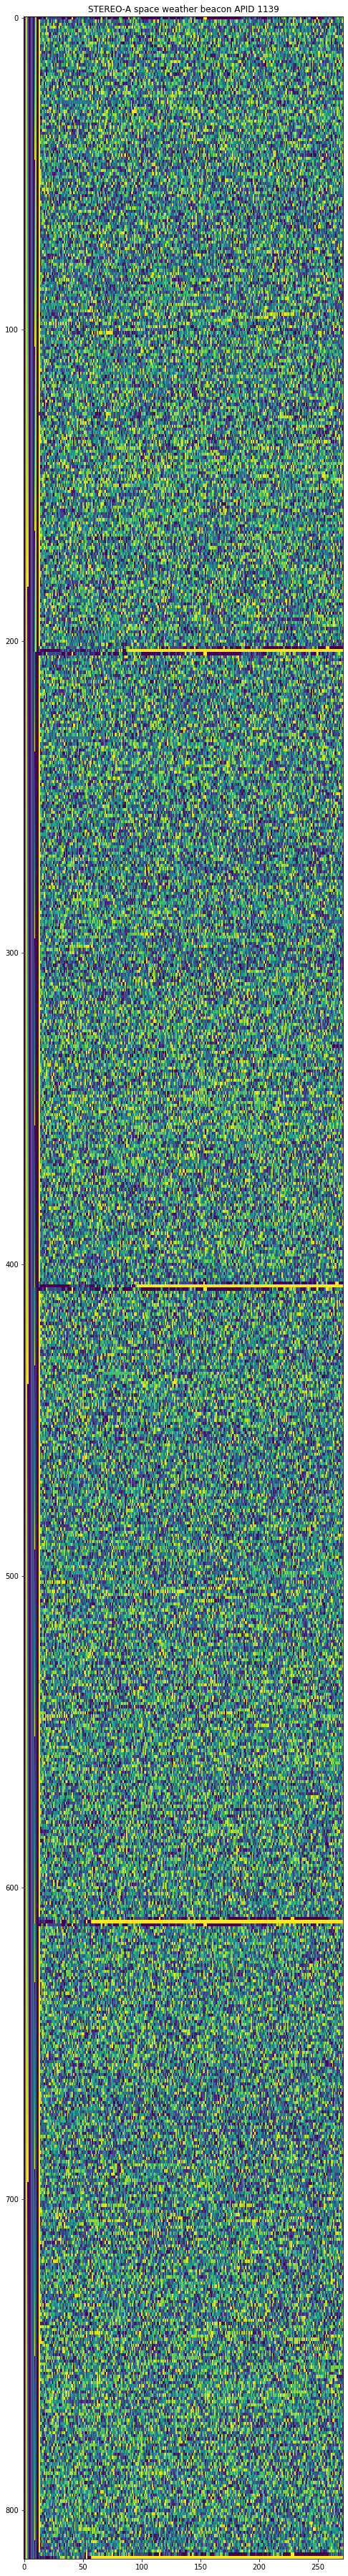

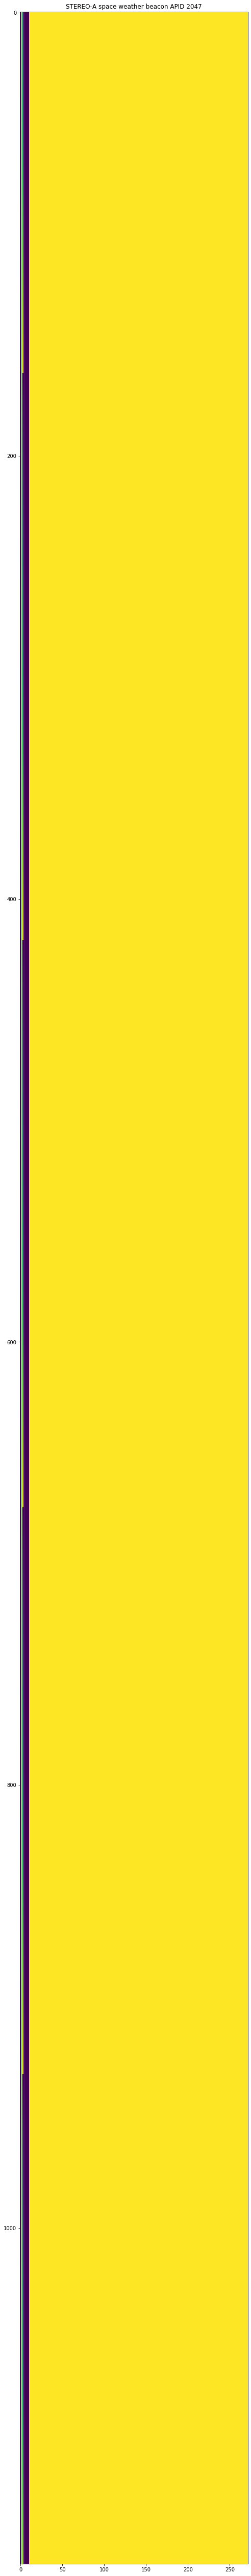

In [43]:
#for apid in apids:
#    data = by_apid[apid]
#    plt.figure(figsize=(8, 8 * data.shape[0] / 100))
#    plt.imshow(data, interpolation='none', aspect='auto')
#    plt.title(f'STEREO-A space weather beacon APID {apid}')
import numpy as np
import matplotlib.pyplot as plt

def write_binary_file(data_array, file_path):
    # Convert the array to bytes
    data_bytes = data_array.tobytes()

    # Write the bytes to a file
    with open(file_path, 'wb') as file:
        file.write(data_bytes)

def write_apids_to_files(apids, by_apid):
    for apid in apids:
        data = by_apid[apid]

        # Generate a unique file name for each APID
        file_path = f'output_{apid}.bin'

        # Write the data to a binary file
        write_binary_file(data, file_path)

        # Plotting code (optional)
        plt.figure(figsize=(8, 8 * data.shape[0] / 100))
        plt.imshow(data, interpolation='none', aspect='auto')
        plt.title(f'STEREO-A space weather beacon APID {apid}')
        plt.show()

write_apids_to_files(apids, by_apid)
    

In [44]:
non_idle = [h.APID != 2047 for h in packet_headers]
packet_timestamps_secs = np.array(space_packets)[non_idle, 6:10].view('uint32').byteswap().ravel()

In [45]:
datetime.datetime(2022, 9, 24, 10, 35, 0) - datetime.timedelta(seconds=int(packet_timestamps_secs[0]))

datetime.datetime(1957, 3, 21, 23, 51, 21)

In [46]:
ccsds_epoch = np.datetime64('1958-01-01T00:00:00')
packet_timestamps = ccsds_epoch + np.timedelta64(1, 's') * packet_timestamps_secs
packet_timestamps[0]

numpy.datetime64('2023-07-06T10:43:39')

In [47]:
apids_for_timestamps = np.array([h.APID for h in packet_headers if h.APID != 2047])
tmtimestaps_for_timestamps = np.repeat(timestamps[vcid == 7], 4)[non_idle]

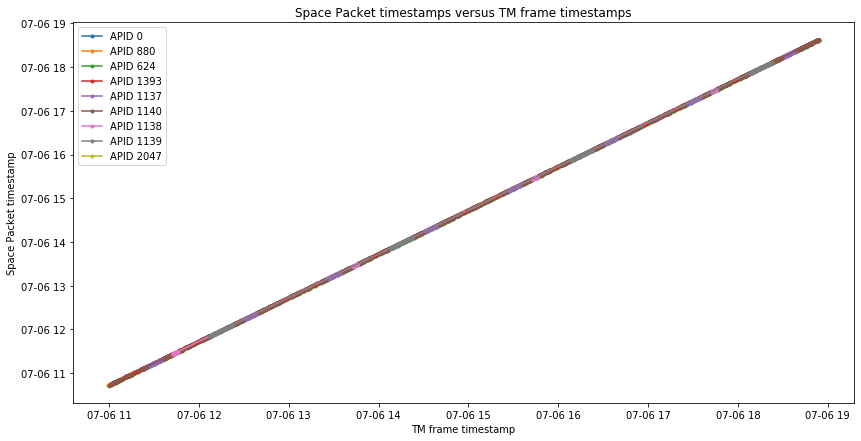

In [48]:
for apid in apids:
    sel = apids_for_timestamps == apid
    plt.plot(tmtimestaps_for_timestamps[sel], packet_timestamps[sel], '.-',
             label=f'APID {apid}')
plt.legend()
plt.title('Space Packet timestamps versus TM frame timestamps')
plt.xlabel('TM frame timestamp')
plt.ylabel('Space Packet timestamp');

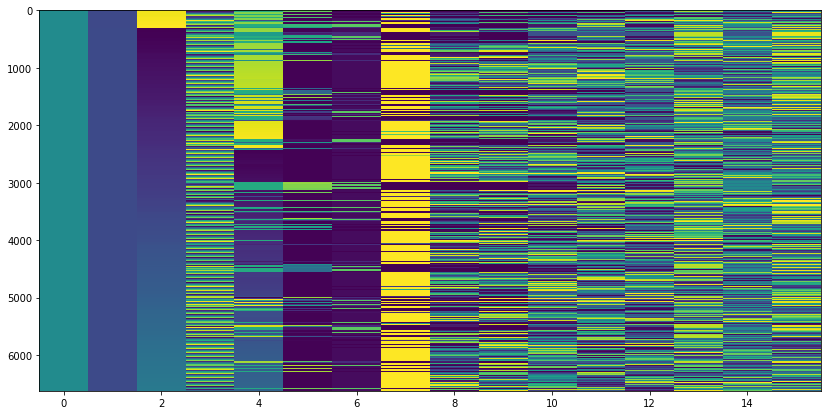

In [49]:
plt.imshow(np.array(space_packets)[non_idle, 6:6+16], aspect='auto', interpolation='none');

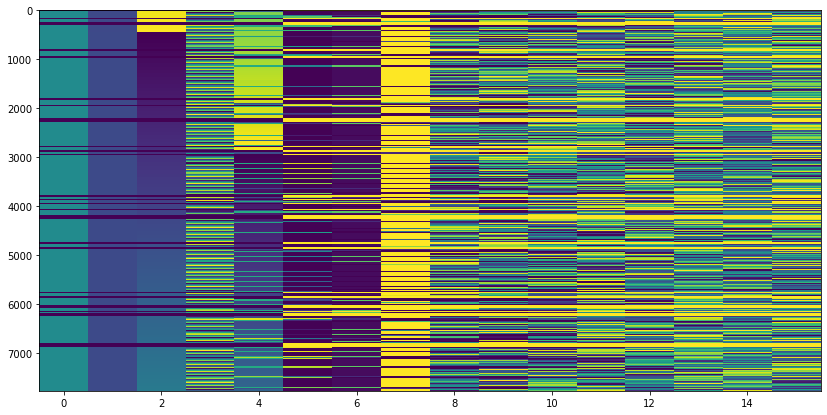

In [50]:
plt.imshow(np.array(space_packets)[:, 6:6+16], aspect='auto', interpolation='none');

## S/WAVES beacon data

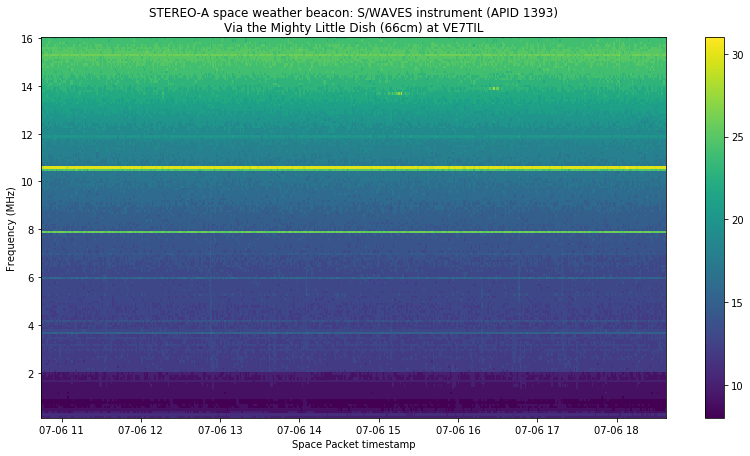

In [51]:
swaves_data = by_apid[1393][:, 29:29+159]
swaves_timestamps = packet_timestamps[apids_for_timestamps == 1393]

plt.imshow(swaves_data.T[::-1], aspect='auto', interpolation='none',
           extent=[mdates.date2num(swaves_timestamps[0]),
                   mdates.date2num(swaves_timestamps[-1]),
                   0.125, 16.025,])
plt.gca().xaxis_date()
plt.colorbar()
plt.title('STEREO-A space weather beacon: S/WAVES instrument (APID 1393)\nVia the Mighty Little Dish (66cm) at VE7TIL')
plt.xlabel('Space Packet timestamp')
plt.ylabel('Frequency (MHz)');

In [52]:
swaves_timestamps

array(['2023-07-06T10:44:23', '2023-07-06T10:45:23',
       '2023-07-06T10:46:23', '2023-07-06T10:47:23',
       '2023-07-06T10:48:23', '2023-07-06T10:49:23',
       '2023-07-06T10:50:23', '2023-07-06T10:51:23',
       '2023-07-06T10:52:23', '2023-07-06T10:53:23',
       '2023-07-06T10:54:23', '2023-07-06T10:55:23',
       '2023-07-06T10:56:23', '2023-07-06T10:57:23',
       '2023-07-06T10:58:23', '2023-07-06T10:59:23',
       '2023-07-06T11:00:23', '2023-07-06T11:01:23',
       '2023-07-06T11:02:23', '2023-07-06T11:03:23',
       '2023-07-06T11:04:23', '2023-07-06T11:05:23',
       '2023-07-06T11:06:23', '2023-07-06T11:07:23',
       '2023-07-06T11:08:23', '2023-07-06T11:09:23',
       '2023-07-06T11:10:23', '2023-07-06T11:11:23',
       '2023-07-06T11:12:23', '2023-07-06T11:13:23',
       '2023-07-06T11:14:23', '2023-07-06T11:15:23',
       '2023-07-06T11:16:23', '2023-07-06T11:17:23',
       '2023-07-06T11:18:23', '2023-07-06T11:19:23',
       '2023-07-06T11:20:23', '2023-07-06T11:2

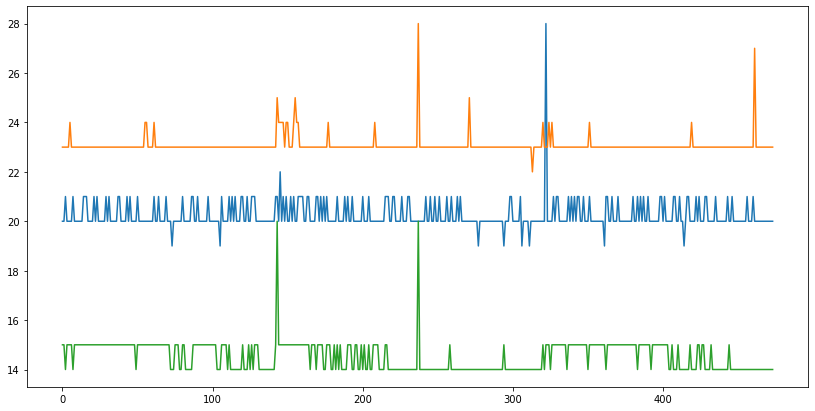

In [53]:
plt.plot(by_apid[1393][:, 26:29]);

Text(0.5, 0, 'Space Packet timestamp')

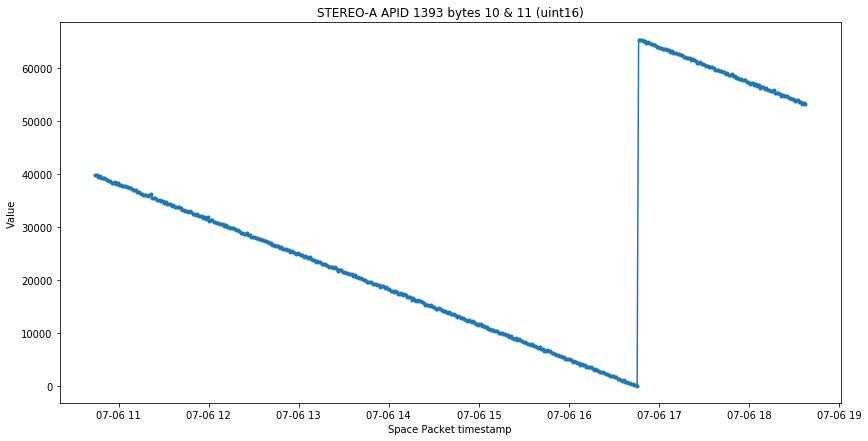

In [54]:
plt.plot(swaves_timestamps, by_apid[1393][:, 10:12].copy().view('uint16').byteswap(), '.-')
plt.title('STEREO-A APID 1393 bytes 10 & 11 (uint16)')
plt.ylabel('Value')
plt.xlabel('Space Packet timestamp')
